# Import libraries

**NOTE:**

You can download the dataset from this link : https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery


Content
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

1.Building: #3C1098

2.Land (unpaved area): #8429F6

3.Road: #6EC1E4

4.Vegetation: #FEDD3A

5.Water: #E2A929

6.Unlabeled: #9B9B9B

In [1]:
import os
import cv2
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from Unet_MultiClass_Model import UNET_MultiClass
import Unet_MultiClass_Model
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler,StandardScaler


Segmentation Models: using `keras` framework.


# Set parameters

In [2]:
ROOT_DIR='aerial_imagery/Semantic segmentation dataset/'

PATCH_SIZE = 256
NUM_CHANNELS = 3
BATCH_SIZE = 16

In [ ]:
"""
['aerial_imagery/Semantic segmentation dataset/Tile 1', 'images'] -->DIR_NAME=path.split(os.path.sep)[-1]
[]
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
"""

# Read any image

Height:1480
Width:2149
Number of channels:3
(1480, 2149, 3)


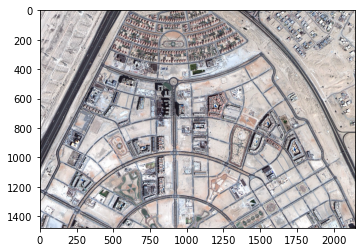

In [3]:
img=cv2.imread('aerial_imagery/Semantic segmentation dataset/Tile 8/images/image_part_006.jpg')
print(f'Height:{img.shape[0]}')
print(f'Width:{img.shape[1]}')
print(f'Number of channels:{img.shape[2]}')
img_arr=np.array(img)
print(img_arr.shape)
plt.imshow(img)

# Informations about dataset

Tile 1 images size = (643,797,3)

After cropping , Tile 1 images size = (512,768,3)

After patchifying , Tile 1 number of images:
    (512/256) x (768/256) = 6 images
--------

Tile 2 images size = (544, 509, 3)

After resizing , Tile 2 images size = (512,256,3)

After patchifying , Tile 2 number of images:

    (512/256) x (256/256) = 2 images
-------
    
Tile 3 images size = (658, 682, 3)

After resizing , Tile 2 images size = (512,512,3)

After patchifying , Tile 2 number of images:

    (512/256) x (512/256) = 4 images
-------    
    
Tile 4 images size = (846, 1099, 3)

After resizing , Tile 4 images size = (768,1024,3)

After patchifying , Tile 4 number of images:

    (768/256) x (1024/256) = 12 images
-------    
    
Tile 5 images size = (1058, 1126, 3)

After resizing , Tile 5 images size = (1024,1024,3)

After patchifying , Tile 5 number of images:

    (1024/256) x (1024/256) = 16 images
-------    

Tile 6 images size = (838, 859, 3)

After resizing , Tile 6 images size = (768,768,3)

After patchifying , Tile 6 number of images:

    (768/256) x (768/256) = 9 images
-------    
    
Tile 7 images size = (2062, 1818, 3)

After resizing , Tile 6 images size = (2048,1792,3)

After patchifying , Tile 6 number of images:

    (2048/256) x (1792/256) = 56 images
-------    
    
Tile 8 images size = (1480, 2149, 3)

After resizing , Tile 8 images size = (1280,2048,3)

After patchifying , Tile 8 number of images:

    (1280/256) x (2048/256) = 40 images
-------    
    
    
**Every tile folder has 9 images.
    145 patches x 9 images = 1305 patches of 256x256 sized.**

# Extract images

In [3]:
scaler=MinMaxScaler()

# Create the list.The list will keep the images
dataset_images = []

for PATH,SUB_DIRS,FILES in os.walk(ROOT_DIR):
    DIR_NAME = PATH.split(os.path.sep)[-1]
    if DIR_NAME == 'images':
        images = os.listdir(PATH)
        
        for idx,IMG_NAME in enumerate(images):
            # Check the file format is '.jpg' or not
            if IMG_NAME.endswith('.jpg'):
                
                img = cv2.imread(PATH+'/'+IMG_NAME,cv2.IMREAD_COLOR) # Read the image with BGR
                # img.shape --> ()
                
                # Set image size for dividing 256 with no remains.
                IMG_HEIGHT = (img.shape[0] // PATCH_SIZE) * PATCH_SIZE # (643 // 256)*256 = 512
                IMG_WIDTH = (img.shape[1] // PATCH_SIZE) * PATCH_SIZE # (797 // 256)*256 = 768
                                       
                # Convert image to array
                img=Image.fromarray(img)
                                       
                # Crop the image
                img = img.crop( (0,0,IMG_WIDTH,IMG_HEIGHT) )
                
                # Convert numpy array
                img=np.array(img)
                
                # Divide the images as 256x256
                print("Patchifying image:",PATH+'/'+IMG_NAME)
                
                # Extract patches from each image
                patches_img=patchify(image=img , patch_size=(PATCH_SIZE,PATCH_SIZE,NUM_CHANNELS) , step=PATCH_SIZE )
                #print(patches_img.shape)
                #patch_img.shape-->(2,3,1,256,256,3) for Tile 1
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img=patches_img[i,j,:,:]
                        single_patch_img=scaler.fit_transform(single_patch_img.reshape(-1,single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        # print(single_patch_img.shape) # (1,256,256,3)
                        single_patch_img=single_patch_img[0] # (256,256,3)
                        
                        dataset_images.append(single_patch_img)
                        
dataset_images=np.array(dataset_images)

print('DONE!!')
            

Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Patchifying image: aerial_imagery/Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Patchifying image: aerial_imag

In [4]:
dataset_images.shape # There are 1305 patches with 256x256 sized

(1305, 256, 256, 3)

# Extract masks(labels)

In [4]:

# Create the list.The list will keep the images
dataset_masks = []

for PATH,SUB_DIRS,FILES in os.walk(ROOT_DIR):
    DIR_NAME = PATH.split(os.path.sep)[-1]
    if DIR_NAME == 'masks':   # Find all 'images' directories
        masks = os.listdir(PATH)   # List of all image names in this subdirectory
        
        for idx,MASK_NAME in enumerate(masks):
            # Check the file format is '.jpg' or not
            if MASK_NAME.endswith('.png'):  # Only read png images... (masks in this dataset)
                
                mask = cv2.imread(PATH+'/'+MASK_NAME,1) # Read the image with BGR
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

                # img.shape --> ()
                
                # Set image size for dividing 256 with no remains.
                MASK_HEIGHT = (mask.shape[0] // PATCH_SIZE) * PATCH_SIZE # (643 // 256)*256 = 512
                MASK_WIDTH = (mask.shape[1] // PATCH_SIZE) * PATCH_SIZE # (797 // 256)*256 = 768
                                       
                # Convert image to array
                mask=Image.fromarray(mask)
                                       
                # Crop the image   # Try not to resize for semantic segmentation
                mask = mask.crop( (0,0,MASK_WIDTH,MASK_HEIGHT) )  # Crop from top left corner
                
                # Convert numpy array
                mask=np.array(mask)
                
                # Divide the images as 256x256
                print("Patchifying mask:",PATH+'/'+MASK_NAME)
                
                # Extract patches from each image
                patches_mask=patchify(image=mask , patch_size=(PATCH_SIZE,PATCH_SIZE,NUM_CHANNELS) , step=PATCH_SIZE )
                #print(patches_mask.shape)
                #patch_mask.shape-->(2,3,1,256,256,3) for Tile 1
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask=patches_mask[i,j,:,:]
                        
                        # print(single_patch_img.shape) # (1,256,256,3)
                        single_patch_mask=single_patch_mask[0] # (256,256,3)
                        
                        dataset_masks.append(single_patch_mask)
                        
dataset_masks=np.array(dataset_masks)

print('DONE!!')

Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_008.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 1\masks/image_part_009.png
Patchifying mask: aerial_imagery/Semantic segmentation dataset/Tile 2\masks/image_part_001.png
Patchifying mask: aerial_imagery/Semantic segmenta

In [6]:
dataset_masks.shape # There are 1305 patches with 256x256 sized

(1305, 256, 256, 3)

# Show any image and its label

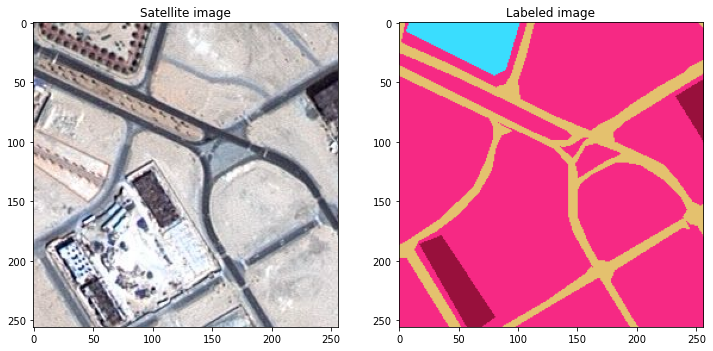

In [113]:
import random
import numpy as np
image_number = random.randint(0, len(dataset_images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Satellite image')
plt.imshow(np.reshape(dataset_images[image_number], (PATCH_SIZE, PATCH_SIZE, 3)))
plt.subplot(122)
plt.title('Labeled image')
plt.imshow(np.reshape(dataset_masks[image_number], (PATCH_SIZE,PATCH_SIZE, 3)))
plt.show()

# Convert HEX to RGB

**RGB to HEX: (Hexadecimel --> base 16)**

This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 


0-9 --> 0-9

10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098

3C = 3*16 + 12 = 60

10 = 1*16 + 0 = 16

98 = 9*16 + 8 = 152 

In [5]:
# Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

print(f"Building:{Building}")
print(f"Land:{Land}")
print(f"Road:{Road}")
print(f"Vegetation:{Vegetation}")
print(f"Water:{Water}")
print(f"Unlabeled:{Unlabeled}")

60
Building:[ 60  16 152]
Land:[132  41 246]
Road:[110 193 228]
Vegetation:[254 221  58]
Water:[226 169  41]
Unlabeled:[155 155 155]


# Convert RGB to labels and Display Masked Labels

In [6]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [7]:
def display_one_label(mask,displaying_label):
    label_mask = np.zeros(mask.shape,dtype=np.uint8)
    
    if displaying_label=='Building':
        label_mask [np.any(mask == Building,axis=-1)] = Building
        plt.title('Buildings')
        plt.imshow(label_mask)
    elif displaying_label=='Land':
        label_mask [np.any(mask == Land,axis=-1)] = Land
        plt.title('Lands')
        plt.imshow(label_mask)
    elif displaying_label=='Road':
        label_mask [np.any(mask == Road,axis=-1)] = Road
        plt.title('Roads')
        plt.imshow(label_mask)
    elif displaying_label=='Vegetation':
        label_mask [np.any(mask == Vegetation,axis=-1)] = Vegetation
        plt.title('Vegetations')
        plt.imshow(label_mask)
    elif displaying_label=='Water':
        label_mask [np.any(mask == Water,axis=-1)] = Water
        plt.title('Waters')
        plt.imshow(label_mask)
    elif displaying_label=='Unlabeled':
        label_mask [np.any(mask == Unlabeled,axis=-1)] = Unlabeled
        plt.title('Unlabeled')
        plt.imshow(label_mask)
        
        

In [8]:
def display_random_masks(images,masks):
    """
    It chooses any random number to choose random mask on mask dataset and display masks
    """
    
    rand_num=random.randint(0,masks.shape[0])
    plt.figure(figsize=(20,14))

    # Display image
    plt.subplot(241)
    plt.title('Original image')
    plt.imshow(images[rand_num])

    # Display mask
    plt.subplot(242)
    plt.title('Mask')
    plt.imshow(masks[rand_num])

    # Display building mask
    plt.subplot(243)
    plt.title('Buildings')
    display_one_label(masks[rand_num],displaying_label='Building')

    # Display vegetation mask
    plt.subplot(244)
    plt.title('Lands')
    display_one_label(masks[rand_num],displaying_label='Land')

    # Display water mask
    plt.subplot(245)
    plt.title('Roads')
    display_one_label(masks[rand_num],displaying_label='Road')

    # Display unlabeled mask
    plt.subplot(246)
    plt.title('Vegetations')
    display_one_label(masks[rand_num],displaying_label='Vegetation')
    
    # Display building mask
    plt.subplot(247)
    plt.title('Waters')
    display_one_label(masks[rand_num],displaying_label='Water')

    # Display building mask
    plt.subplot(248)
    plt.title('Unlabeled')
    display_one_label(masks[rand_num],displaying_label='Unlabeled')
    

    
    print(f'Choosing idx:{rand_num}')



Choosing idx:1134


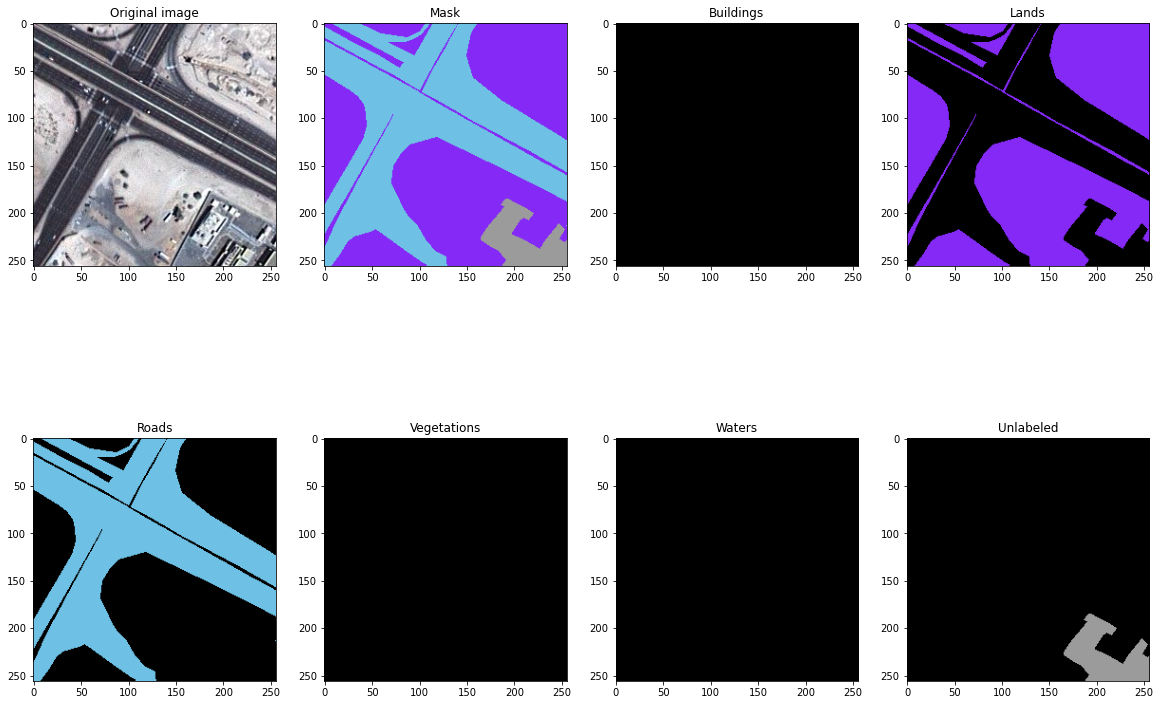

In [31]:
display_random_masks(dataset_images,dataset_masks)

In [7]:
labels=[]

for i in range(dataset_masks.shape[0]):
    label=rgb_to_2D_label(dataset_masks[i])
    labels.append(label)
    
labels=np.array(labels)
labels=np.expand_dims(labels,axis=3)
print(labels.shape)

(1305, 256, 256, 1)


In [10]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [34]:
labels[0][:10]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

# Categorize labels

In [8]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [12]:
print(labels_cat.shape)
print(n_classes)

(1305, 256, 256, 6)
6


In [40]:
labels_cat[0]

array([[[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]],

       ...,

       [[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        .

# Split train and test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dataset_images, labels_cat, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1044, 256, 256, 3)
(1044, 256, 256, 6)
(261, 256, 256, 3)
(261, 256, 256, 6)


# Setting parameters

In [10]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [11]:
from Unet_MultiClass_Model import UNET_MultiClass,jacard_coef
metrics=['accuracy',jacard_coef]

In [12]:
def get_model():
    return UNET_MultiClass(n_classes=n_classes,IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_HEIGHT,
                           IMG_CHANNELS=IMG_CHANNELS)

model=get_model()
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

# Training the model

In [14]:
import time
start=time.time()

with tf.device("/cpu:0"):
    history1=model.fit(X_train,Y_train,batch_size=BATCH_SIZE,
                      verbose=1,epochs=15,
                      validation_data=(X_test,Y_test),
                      shuffle=False)
    
end=time.time()
seconds=int(end-start)
minutes=int((end-start) / 60)


print(f'Model training took {seconds} seconds , {minutes} minutes.')

Epoch 1/15
66/66 [==============================] - 330s 5s/step - loss: 0.9787 - accuracy: 0.6300 - jacard_coef: 0.3293 - val_loss: 0.9667 - val_accuracy: 0.6812 - val_jacard_coef: 0.3869
Epoch 2/15
66/66 [==============================] - 325s 5s/step - loss: 0.9694 - accuracy: 0.6570 - jacard_coef: 0.3719 - val_loss: 0.9714 - val_accuracy: 0.6666 - val_jacard_coef: 0.3920
Epoch 3/15
66/66 [==============================] - 324s 5s/step - loss: 0.9733 - accuracy: 0.6500 - jacard_coef: 0.3520 - val_loss: 0.9638 - val_accuracy: 0.6912 - val_jacard_coef: 0.3733
Epoch 4/15
66/66 [==============================] - 324s 5s/step - loss: 0.9663 - accuracy: 0.6647 - jacard_coef: 0.3859 - val_loss: 0.9636 - val_accuracy: 0.6849 - val_jacard_coef: 0.4074
Epoch 5/15
66/66 [==============================] - 323s 5s/step - loss: 0.9629 - accuracy: 0.6737 - jacard_coef: 0.4121 - val_loss: 0.9604 - val_accuracy: 0.6996 - val_jacard_coef: 0.4436
Epoch 6/15
66/66 [==============================] - 325

# Display the results

In [15]:
train_acc=history1.history['accuracy']
train_loss=history1.history['loss']
test_acc=history1.history['val_accuracy']
test_loss=history1.history['val_loss']

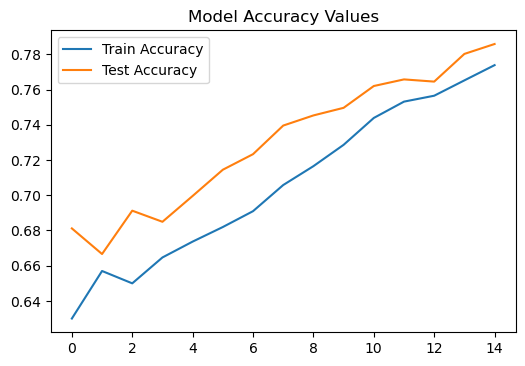

In [16]:
plt.figure(dpi=100)
plt.plot(train_acc,label="Train Accuracy")
plt.plot(test_acc,label="Test Accuracy")
plt.title("Model Accuracy Values")
plt.legend()
plt.show()

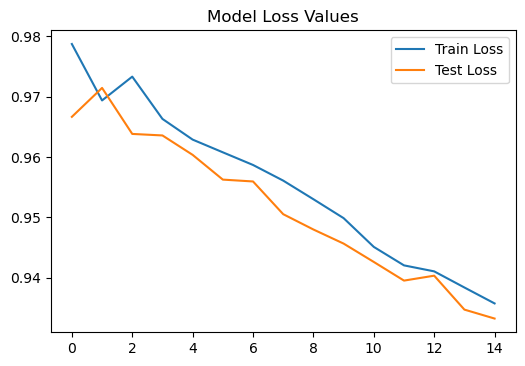

In [17]:
plt.figure(dpi=100)
plt.plot(train_loss,label="Train Loss")
plt.plot(test_loss,label="Test Loss")
plt.title("Model Loss Values")
plt.legend()
plt.show()

In [26]:
with tf.device('/cpu:0'):
    model.evaluate(X_test,Y_test)

9/9 [==============================] - 12s 1s/step - loss: 0.9315 - accuracy: 0.7858 - jacard_coef: 0.5729


# Save the model and weights

In [ ]:
model.save("aerial_imagery_model.h5") # Save the model
model.save_weights("aerial_imagery_weights.h5") # Save the weights

# Load the model

In [ ]:
history1=model.load_weights("aerial_imagery_weights.h5")

# Predict test image

In [24]:
Y_test_argmax=np.argmax(Y_test,axis=3)


rand_num=random.randint(0,len(X_test))
print("random num:",rand_num)
test_img=X_test[rand_num]
print(test_img.shape)
test_img_label=Y_test_argmax[rand_num]
print("test_img_label.shape:",test_img_label.shape)

# Convert 4-dimensional to test image for prediction
test_img_input=np.expand_dims(test_img,axis=0)
print("test_img.shape",test_img.shape)

with tf.device('/cpu:0'):
    prediction=model.predict(test_img_input)
    print("prediction.shape",prediction.shape)
    predicted_img=np.argmax(prediction,axis=3)[0,:,:]
    print("predicted_img.shape",predicted_img.shape)


random num: 184
(256, 256, 3)
test_img_label.shape: (256, 256)
test_img.shape (256, 256, 3)
prediction.shape (1, 256, 256, 6)
predicted_img.shape (256, 256)


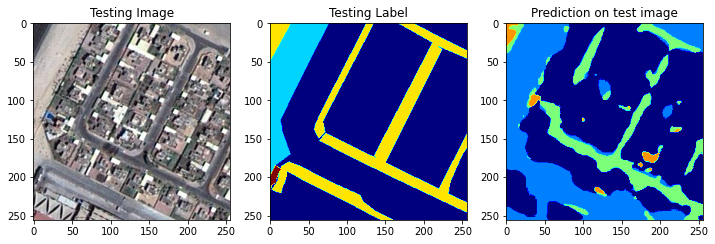

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img,cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img_label,cmap="jet")

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap='jet')

plt.show()